# 1. Importing Libraries

In [1]:
#Basic Libraries
#!pip install modin[all]
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import time

#Preprocessing & Feature Engineering
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#ML Model
import xgboost as xgb
from xgboost import XGBClassifier


# For tuning and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

#Other useful libraries
from collections import Counter
import re

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# 2. Load Data & Exploratory Data Analysis

In [ ]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

print(train_transaction.shape)
print(train_identity.shape)

train_transaction.hist(figsize=(200, 50), bins=50, edgecolor="black")
plt.suptitle("Feature Distributions in Train Transaction Dataset", fontsize=16)
plt.show()

(590540, 394)
(144233, 41)


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7bbfa1d3c2c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py", line 195, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))

KeyboardInterrupt: 


#### Get to know the data more:
* These histograms showed number of unique values for each feature, skewness, and type of the feature (categorical, numerical).
* The distributions of the data shows that feature selection is needed in our dataset like V324.
* The missing values function shows us a repeated factor of missing data which is significant in the feature selection so we don't lose important info when removing many features.
* A feature with many missing values should be removed only if it's not missing in fraudulent cases—because its presence might actually indicate fraud.

In [6]:
def show_missing_values_in_chunks(df, chunk_size=10):
    """
    Show the number of missing values for every feature in chunks of the specified size.

    Parameters:
        df (pandas.DataFrame): The dataframe to analyze.
        chunk_size (int): The number of columns to display in each chunk.
    """
    # Get the number of missing values per column
    missing_values = df.isnull().sum()

    # Split the missing values into chunks
    num_chunks = len(df.columns) // chunk_size + (1 if len(df.columns) % chunk_size != 0 else 0)

    # Display the chunks
    for i in range(num_chunks):
        chunk_start = i * chunk_size
        chunk_end = min((i + 1) * chunk_size, len(df.columns))
        print(f"\n🔍 Chunk {i + 1} ({chunk_start + 1}-{chunk_end}):")
        print(missing_values.iloc[chunk_start:chunk_end])

show_missing_values_in_chunks(train_transaction, chunk_size=10)


🔍 Chunk 1 (1-10):
TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
dtype: int64

🔍 Chunk 2 (11-20):
card6              1571
addr1             65706
addr2             65706
dist1            352271
dist2            552913
P_emaildomain     94456
R_emaildomain    453249
C1                    0
C2                    0
C3                    0
dtype: int64

🔍 Chunk 3 (21-30):
C4     0
C5     0
C6     0
C7     0
C8     0
C9     0
C10    0
C11    0
C12    0
C13    0
dtype: int64

🔍 Chunk 4 (31-40):
C14         0
D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
dtype: int64

🔍 Chunk 5 (41-50):
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
M1     271100
M2     271100
M3     271100
M4     281444
dtype: in

In [ ]:
# Check missing values specifically when isFraud == 1
missing_fraud = train_transaction[train_transaction["isFraud"] == 1].isnull().sum() / len(train_transaction[train_transaction["isFraud"] == 1]) * 100
missing_overall = train_transaction.isnull().sum() / len(train_transaction) * 100

# Show features where more than 50% values are missing when isFraud == 1
high_missing = missing_fraud[missing_fraud > 80].index
print(f"Features with more than 80% missing values when isFraud = 1: {list(high_missing)}")
print(f"Number of feauters removed: {len(high_missing)}")


#train_transaction.drop(columns=high_missing, inplace=True)


Features with more than 80% missing values when isFraud = 1: ['dist2', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']
Number of feauters removed: 48


# 3. Encoding the Data:
1. Why did we encode all the numeric columns to float:
  * Since our model will be XGBoost we ensure optimal speed for float and avoid unexpected errors due to  int/float mismatches.
2. Why using encode_LE instead of LabelEncoder:
  * Due to the large amount of data and features we needed a more efficient function that avoids crashing the session when encoding and encodes according to the values of the column.
3. Why did we use Target Encoding instead of Label Encoding for high cardinality categorical features?
  * The model may misinterpret the numerical ordering.
  * Memory inefficiency with too many categories.
  * Inject directly the influence of a value on the fraud which is good for decision trees and XGBoost.

In [ ]:

# Identify numeric & categorical columns
numeric_cols = train_transaction.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = train_transaction.select_dtypes(include=["object"]).columns.tolist()

# Convert all numeric features to float (XGBoost prefers float)
train_transaction[numeric_cols] = train_transaction[numeric_cols].astype("float")

# Function to encode categorical features
def encode_LE(col, df):
    """Label Encodes a categorical column and optimizes memory usage."""
    df_comb, _ = df[col].factorize(sort=True)  # Factorize sorts values before encoding
    if df_comb.max() > 32000:
        df[col] = df_comb.astype("int32")
    else:
        df[col] = df_comb.astype("int16")
    del df_comb
    gc.collect()  # Free up memory

# Encode categorical features with few unique values using Label Encoding
label_enc_cols = [col for col in categorical_cols if train_transaction[col].nunique() < 20]  # Threshold: 20 unique values

for col in label_enc_cols:
    train_transaction[col] = train_transaction[col].fillna("Missing")  # Handle missing values
    encode_LE(col, train_transaction)

# Encode high-cardinality categorical features using Target Encoding
target_enc_cols = [col for col in categorical_cols if col not in label_enc_cols]

for col in target_enc_cols:
    fraud_mean = train_transaction.groupby(col)["isFraud"].mean()  # Mean target encoding
    train_transaction[col] = train_transaction[col].map(fraud_mean)  # Replace categories with mean fraud probability
    train_transaction[col].fillna(train_transaction["isFraud"].mean(), inplace=True)  # Fill missing values

print(train_transaction.dtypes)


TransactionID     float64
isFraud           float64
TransactionDT     float64
TransactionAmt    float64
ProductCD           int16
                   ...   
V335              float64
V336              float64
V337              float64
V338              float64
V339              float64
Length: 394, dtype: object


# 4. Importance & Relationship of Features:

## Why using XGBoost for feature selection:
Now check the most important features and there correlation by using a mock XGBoost model:
Why so? Due its default handling to missing data, and the computation of non-linear relationships.
XGBoost has a "scale_pos_weight" parameter to handle this by giving more weight to minority class (fraud cases). This will help us later on to decide to remove a feature or no.

**Feature Importance: 1 to 20**
['V201', 'V258', 'V70', 'V156', 'V147', 'V91', 'V294', 'V308', 'C14', 'V103', 'C12', 'V72', 'V149', 'C1', 'V198', 'V80', 'V48', 'V189', 'addr2', 'C8']


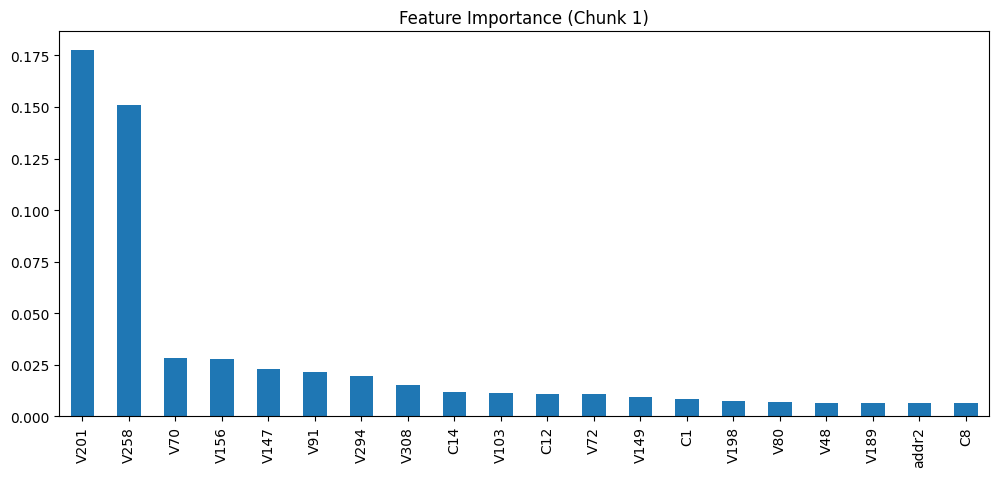

**Feature Importance: 21 to 40**
['R_emaildomain', 'V187', 'V223', 'card6', 'V332', 'V326', 'V219', 'V62', 'V172', 'V227', 'V283', 'V45', 'V142', 'C4', 'D2', 'C11', 'V323', 'V64', 'V167', 'V335']


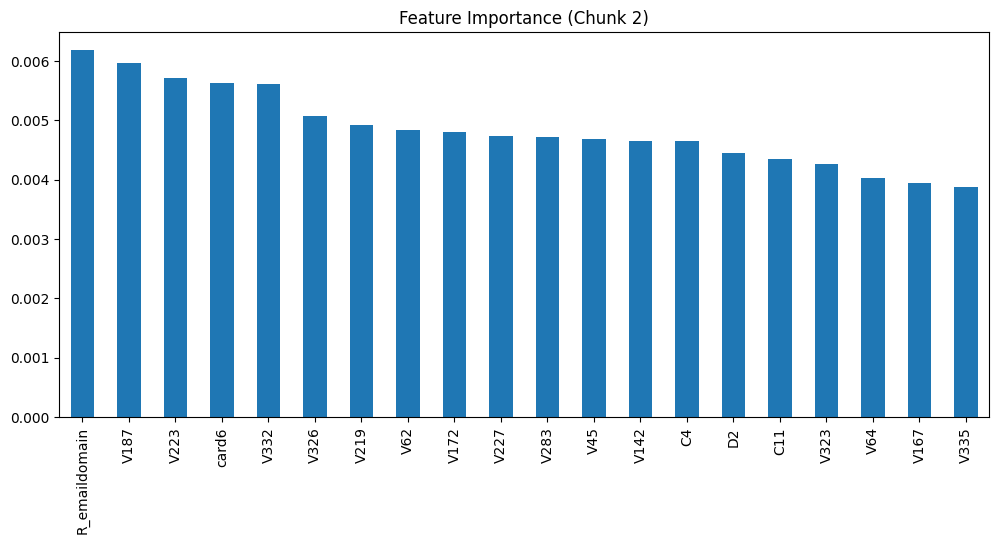

**Feature Importance: 41 to 60**
['V109', 'V298', 'V296', 'C13', 'V82', 'V130', 'V315', 'V318', 'TransactionDT', 'V170', 'V133', 'V79', 'V266', 'C6', 'V162', 'V248', 'M4', 'V194', 'D3', 'card3']


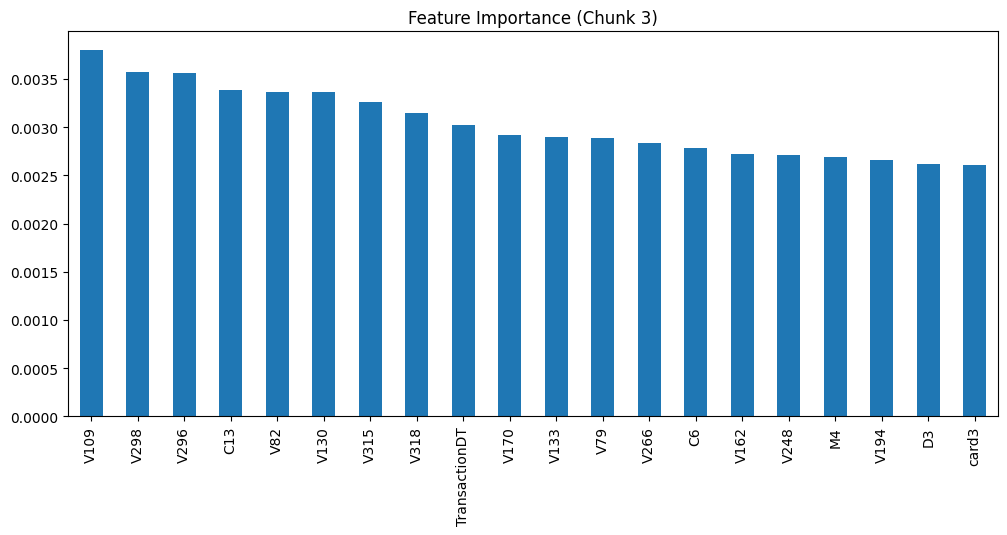

**Feature Importance: 61 to 80**
['V112', 'V33', 'V237', 'V12', 'V152', 'V76', 'V225', 'V192', 'V99', 'V53', 'M5', 'ProductCD', 'V66', 'D10', 'V36', 'V77', 'V17', 'TransactionAmt', 'M6', 'V290']


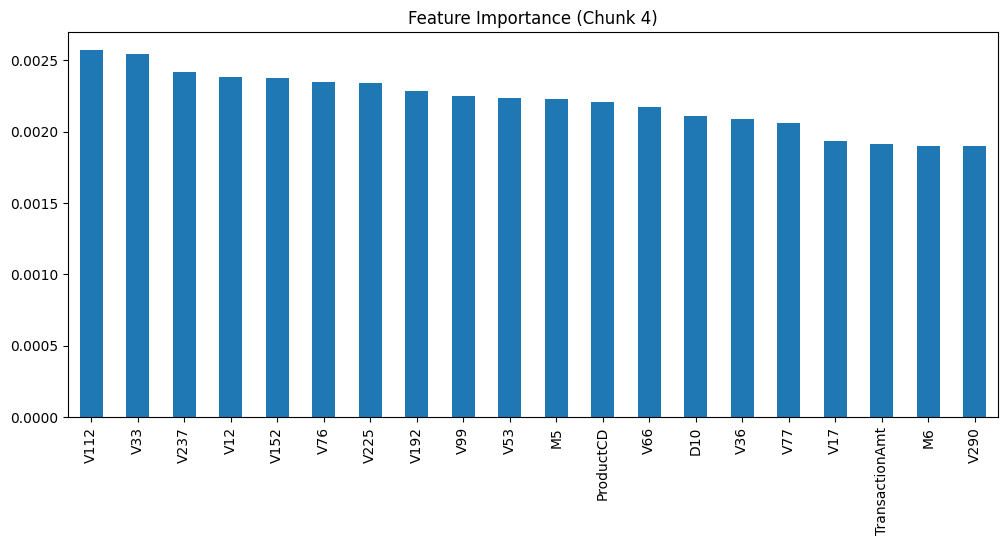

**Feature Importance: 81 to 100**
['V165', 'V164', 'V251', 'V57', 'V155', 'V94', 'V55', 'D4', 'V171', 'V193', 'C9', 'V339', 'V205', 'V87', 'V129', 'V75', 'V324', 'card2', 'V56', 'V314']


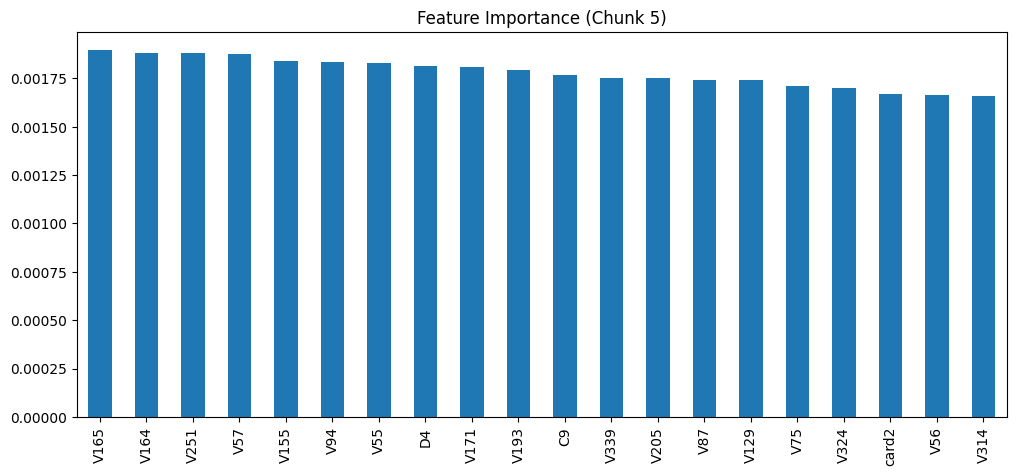

**Feature Importance: 101 to 120**
['D6', 'P_emaildomain', 'C2', 'V262', 'V54', 'V125', 'V291', 'V4', 'V83', 'V281', 'V74', 'V61', 'card5', 'D15', 'V161', 'D1', 'V285', 'V123', 'D13', 'C5']


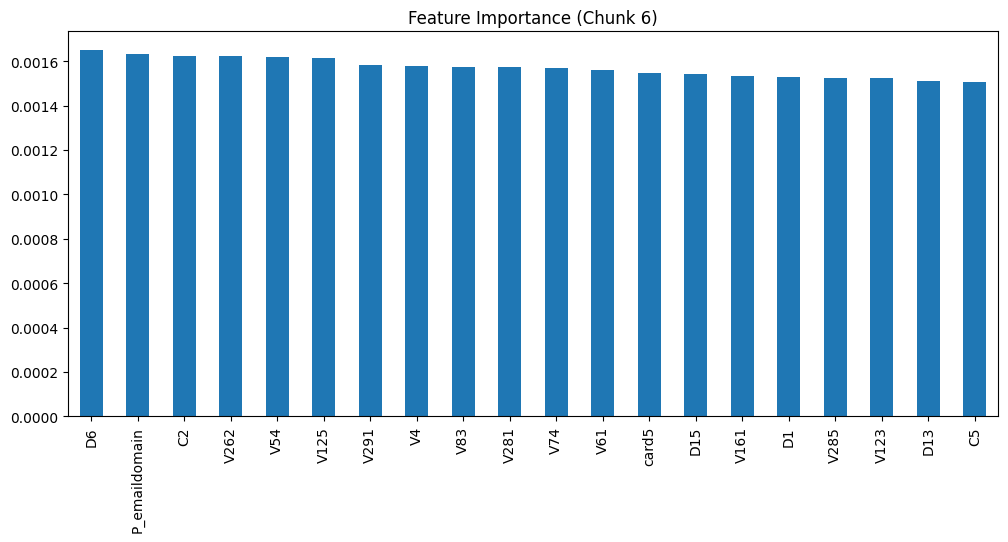

**Feature Importance: 121 to 140**
['V102', 'dist1', 'V38', 'V34', 'V131', 'V208', 'addr1', 'M8', 'D8', 'V220', 'V13', 'V25', 'V69', 'V143', 'V245', 'M9', 'V85', 'V128', 'V277', 'V169']


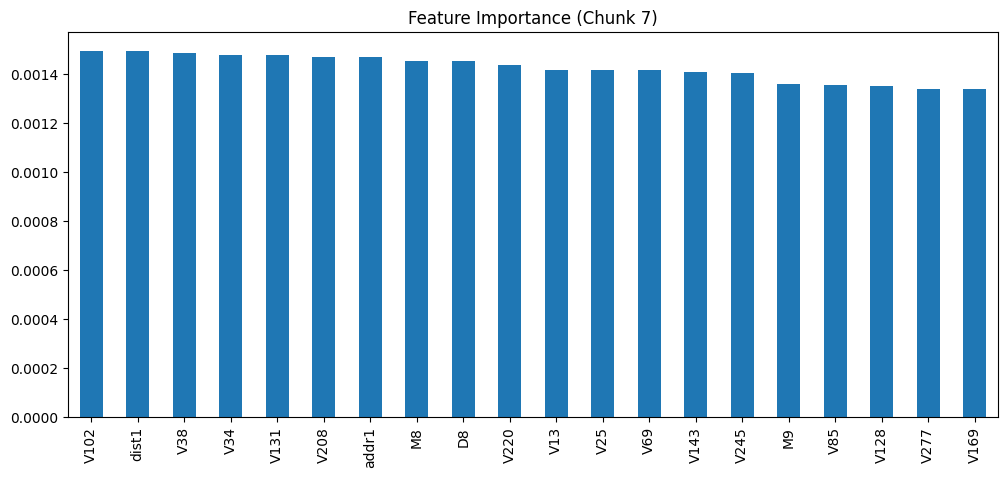

**Feature Importance: 141 to 160**
['M3', 'V58', 'V233', 'C10', 'V312', 'V203', 'V253', 'V209', 'V327', 'V184', 'V49', 'card1', 'V267', 'V244', 'TransactionID', 'V235', 'V26', 'V313', 'V35', 'D14']


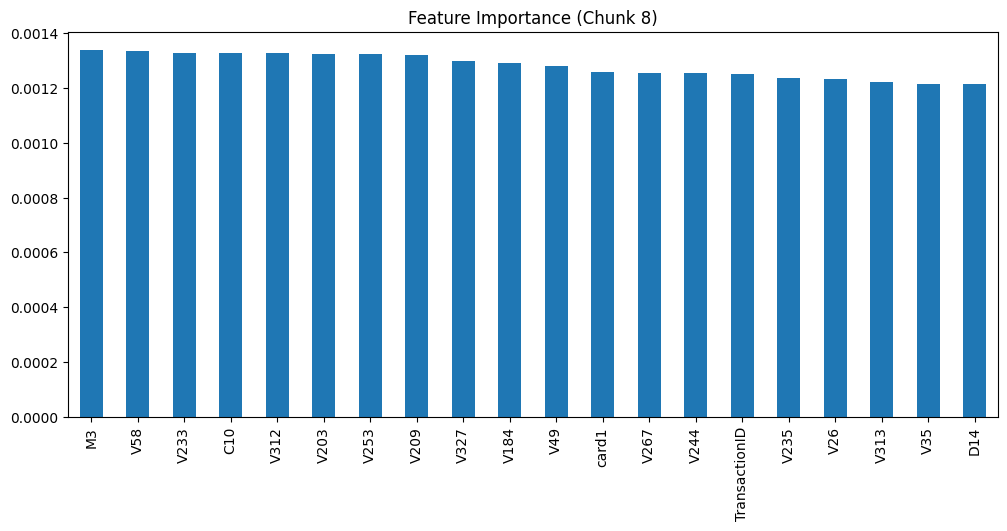

**Feature Importance: 161 to 180**
['V282', 'V257', 'V249', 'V310', 'V78', 'V301', 'V20', 'V67', 'V256', 'V137', 'V92', 'V261', 'V271', 'V280', 'C3', 'V278', 'V10', 'V47', 'V30', 'V175']


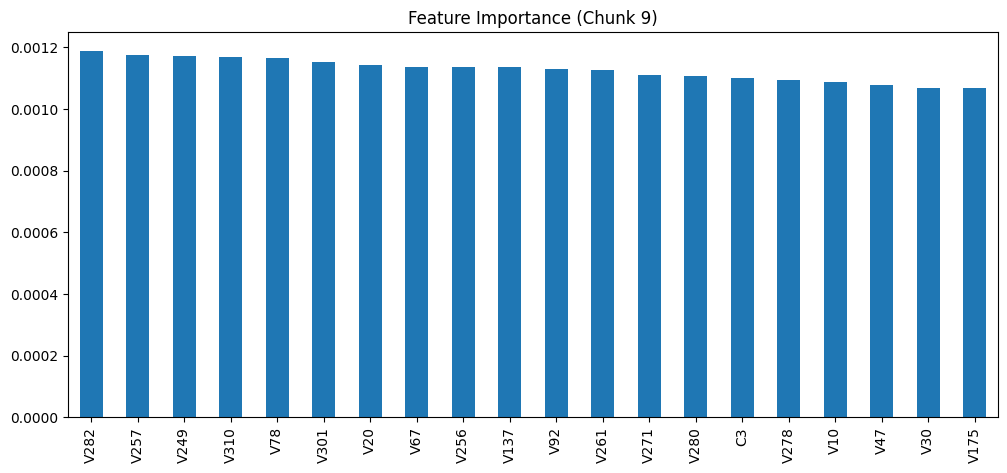

**Feature Importance: 181 to 200**
['V210', 'V202', 'D5', 'V188', 'V140', 'V311', 'V317', 'V60', 'V288', 'V320', 'V160', 'V5', 'V39', 'V44', 'V86', 'V243', 'V185', 'V24', 'V216', 'V139']


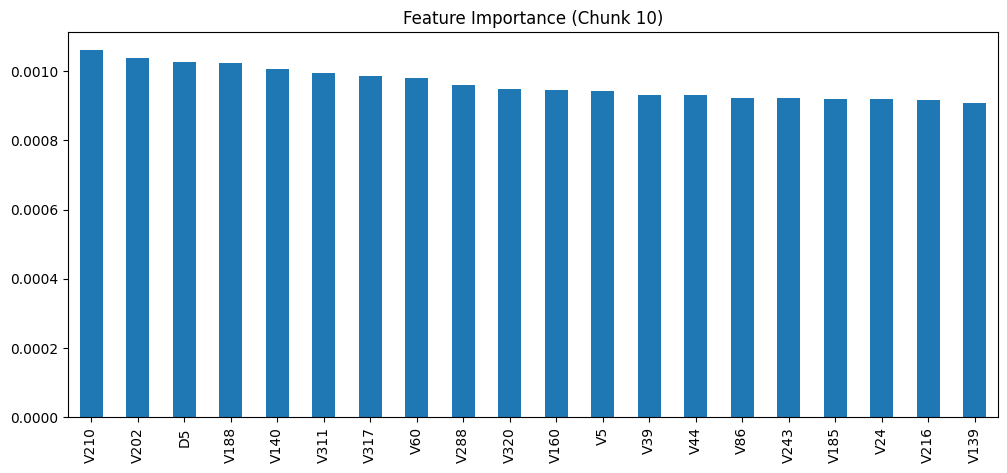

**Feature Importance: 201 to 220**
['V7', 'V307', 'card4', 'V81', 'D11', 'V32', 'V43', 'V23', 'V146', 'V229', 'V157', 'V221', 'V293', 'V289', 'V181', 'V329', 'V132', 'D12', 'V268', 'V274']


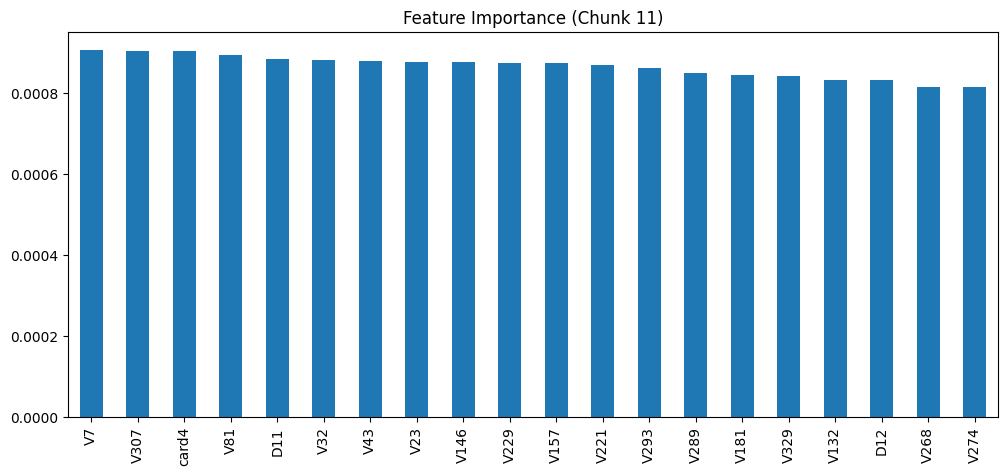

**Feature Importance: 221 to 240**
['V37', 'V228', 'V300', 'V96', 'V19', 'V135', 'V63', 'V166', 'V124', 'V206', 'V136', 'V292', 'V234', 'V224', 'V242', 'V151', 'V273', 'V134', 'V145', 'V29']


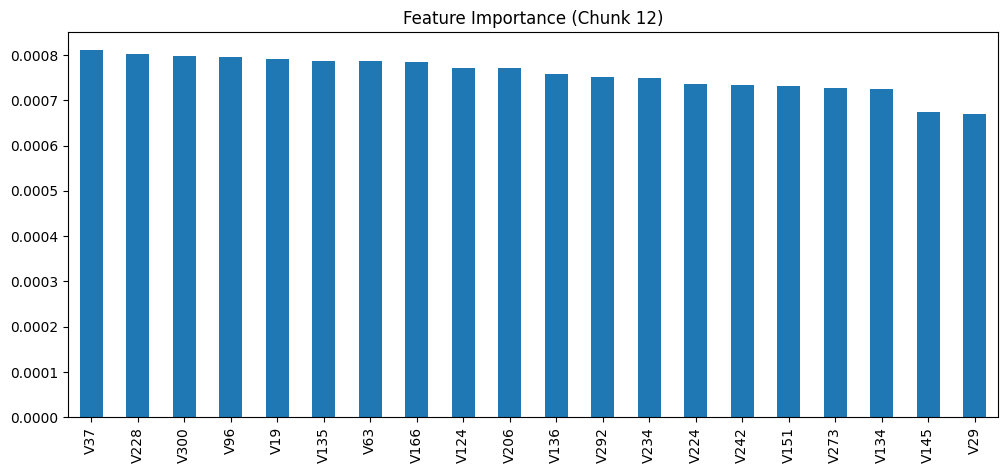

**Feature Importance: 241 to 260**
['V46', 'V111', 'V295', 'V236', 'V338', 'V73', 'V232', 'C7', 'V121', 'V2', 'dist2', 'V215', 'V6', 'V178', 'V299', 'V259', 'V230', 'V222', 'V52', 'V3']


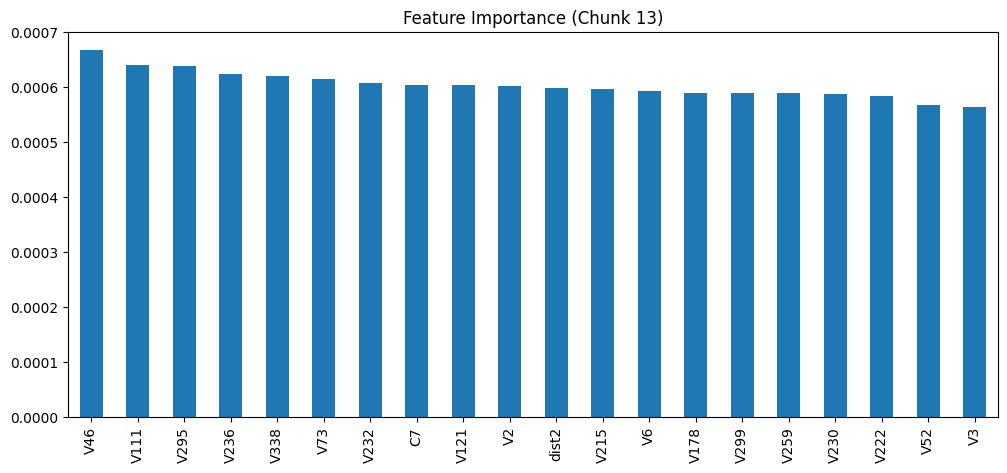

**Feature Importance: 261 to 280**
['V120', 'V212', 'V316', 'V101', 'V239', 'V126', 'V197', 'V321', 'V8', 'V127', 'V263', 'V284', 'M2', 'V309', 'V150', 'D9', 'V319', 'V199', 'D7', 'V260']


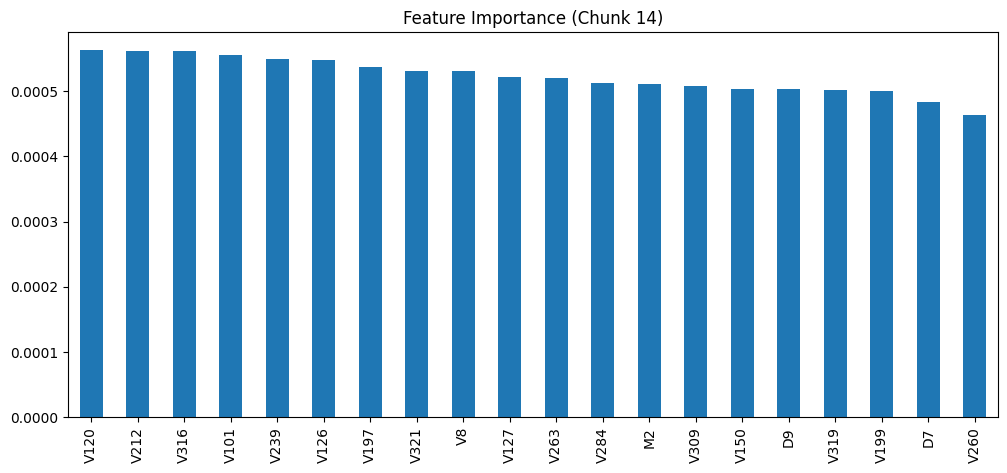

**Feature Importance: 281 to 300**
['V207', 'V97', 'V246', 'V336', 'V200', 'V180', 'V40', 'V287', 'V59', 'V331', 'V238', 'V100', 'V168', 'V90', 'V113', 'V231', 'V183', 'V255', 'V42', 'V174']


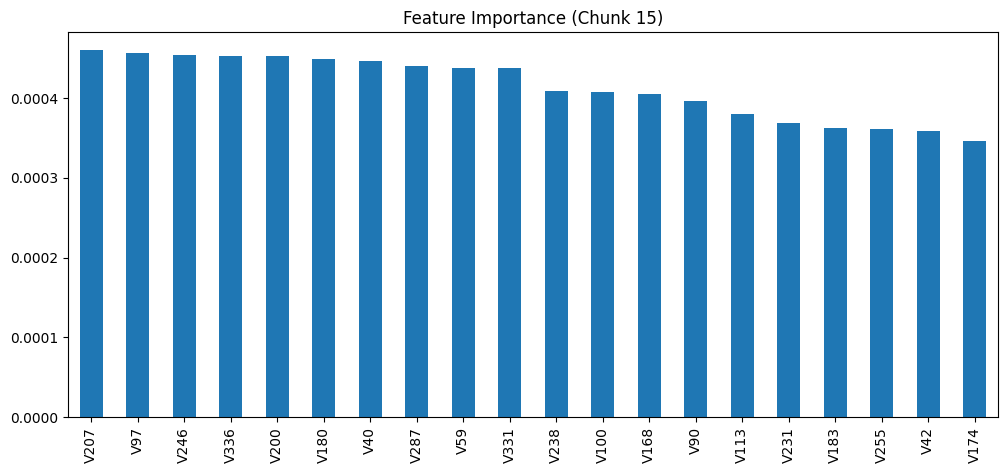

**Feature Importance: 301 to 320**
['M7', 'V204', 'V71', 'V279', 'V264', 'V118', 'V270', 'V226', 'V159', 'V211', 'V148', 'V265', 'V218', 'V303', 'V306', 'V247', 'V217', 'V177', 'V95', 'V302']


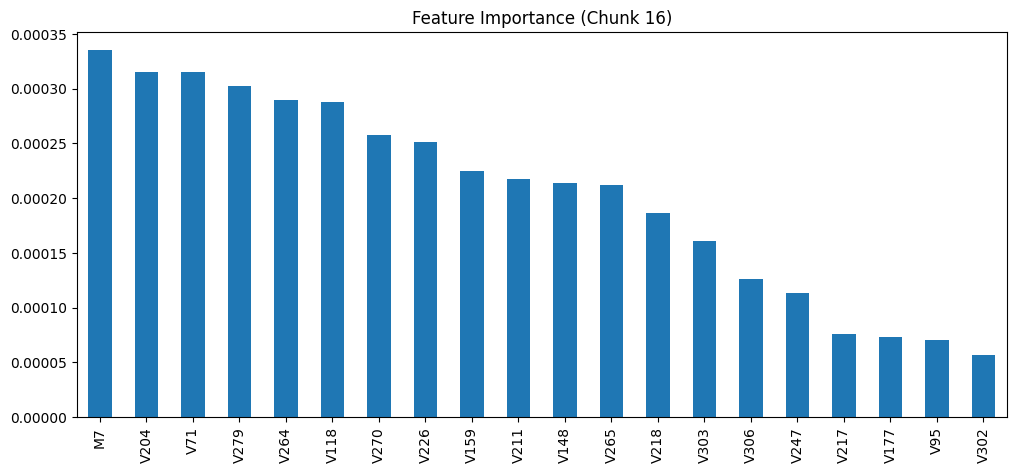

**Feature Importance: 321 to 340**
['V250', 'V214', 'V144', 'V104', 'V84', 'V269', 'V21', 'V191', 'V106', 'V138', 'V22', 'V141', 'V88', 'V119', 'V89', 'V110', 'V117', 'V195', 'V196', 'V190']


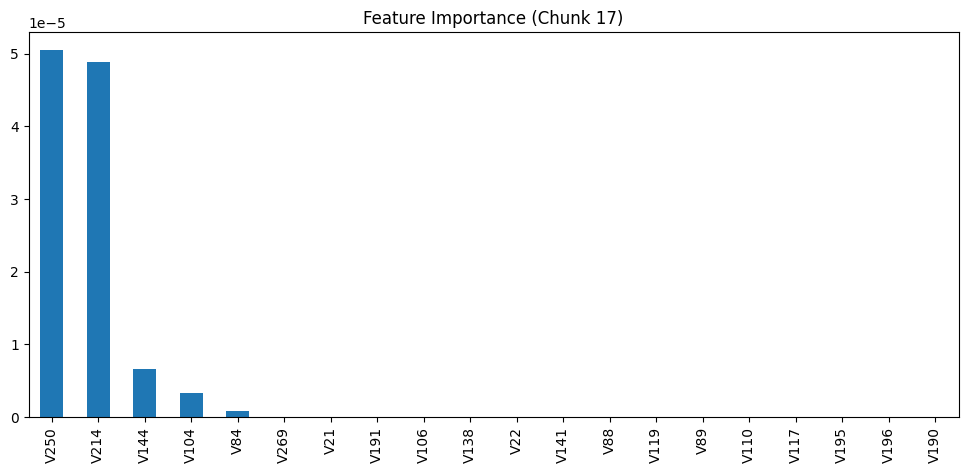

**Feature Importance: 341 to 360**
['V322', 'V305', 'V31', 'V182', 'V337', 'V28', 'V11', 'V334', 'V333', 'V50', 'V176', 'V330', 'V51', 'V328', 'V186', 'V325', 'V252', 'V254', 'V304', 'V15']


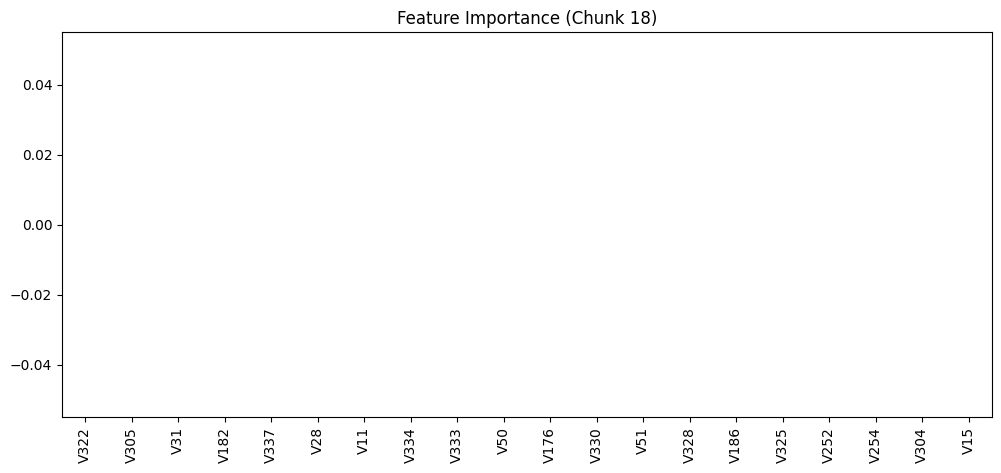

**Feature Importance: 361 to 380**
['V65', 'V115', 'V9', 'V154', 'V27', 'V98', 'V1', 'V122', 'V105', 'V276', 'V275', 'V158', 'V16', 'V272', 'V108', 'V114', 'V286', 'V241', 'V153', 'V240']


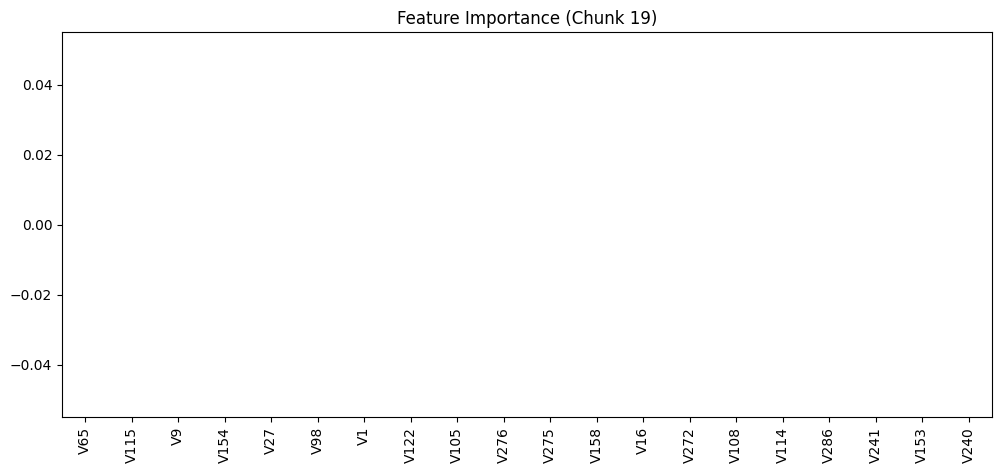

**Feature Importance: 381 to 393**
['V116', 'M1', 'V173', 'V18', 'V107', 'V163', 'V41', 'V297', 'V179', 'V213', 'V14', 'V68', 'V93']


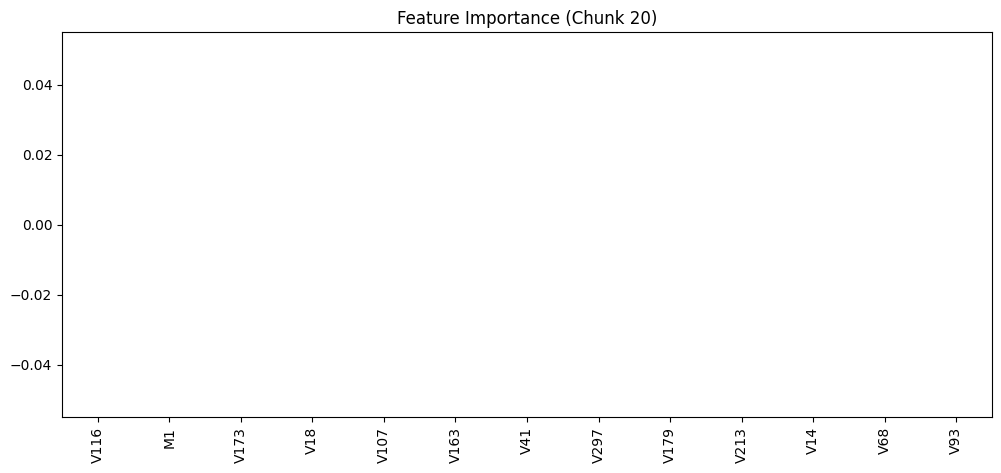

In [ ]:
num_features = [col for col in train_transaction.columns if col != "isFraud"]  # Remove target column
X = train_transaction[num_features]
y = train_transaction["isFraud"]

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", importance_type="gain")
model.fit(X, y)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=num_features).sort_values(ascending=False)


# Function to display features in chunks
def display_importance_in_chunks(feature_importance, chunk_size=20, delay=10):
    features = feature_importance.index.tolist()

    for i in range(0, len(features), chunk_size):
        chunk = features[i:i + chunk_size]  # Select 20 features

        print(f"**Feature Importance: {i+1} to {i+len(chunk)}**")
        print(chunk)

        # Plot feature importance for this chunk
        feature_importance[chunk].plot(kind="bar", figsize=(12,5), title=f"Feature Importance (Chunk {i//chunk_size + 1})")
        plt.show()
        time.sleep(delay)
# Show features in chunks
display_importance_in_chunks(feature_importance)

### Intuition:
We analyze the correlation among anonymous features that share a common prefix, based on the assumption that these prefixes represent related characteristics. To do this, we first extract all the unique prefixes from the feature names for further investigation.
* *Note that* :there is no correlation between the ids in the train identity dataset.

In [ ]:
def get_feature_prefixes(df, min_prefix_length=1, top_n=None):
    """
    Identifies common prefixes in the feature names of a dataframe.

    Parameters:
    - df: DataFrame containing feature columns.
    - min_prefix_length: Minimum length for a prefix (default: 1).
    - top_n: Number of most common prefixes to return (default: None, returns all).

    Returns:
    - Dictionary with prefixes as keys and count of occurrences as values.
    """
    prefix_counter = Counter()

    for col in df.columns:
        for i in range(min_prefix_length, len(col)):  # Check prefixes of different lengths
            prefix = col[:i]
            prefix_counter[prefix] += 1

    # Filter out single occurrences (likely not real prefixes)
    prefix_counter = {k: v for k, v in prefix_counter.items() if v > 1}

    # Sort by frequency and limit to top_n if specified
    sorted_prefixes = dict(sorted(prefix_counter.items(), key=lambda x: x[1], reverse=True))

    if top_n:
        sorted_prefixes = dict(list(sorted_prefixes.items())[:top_n])

    return sorted_prefixes

# Example usage:
prefixes = get_feature_prefixes(train_transaction, min_prefix_length=0, top_n=400)
print(prefixes)

{'': 394, 'V': 339, 'V1': 110, 'V2': 110, 'V3': 50, 'D': 15, 'C': 14, 'V4': 10, 'V5': 10, 'V6': 10, 'V7': 10, 'V8': 10, 'V9': 10, 'V10': 10, 'V11': 10, 'V12': 10, 'V13': 10, 'V14': 10, 'V15': 10, 'V16': 10, 'V17': 10, 'V18': 10, 'V19': 10, 'V20': 10, 'V21': 10, 'V22': 10, 'V23': 10, 'V24': 10, 'V25': 10, 'V26': 10, 'V27': 10, 'V28': 10, 'V29': 10, 'V30': 10, 'V31': 10, 'V32': 10, 'V33': 10, 'M': 9, 'c': 6, 'ca': 6, 'car': 6, 'card': 6, 'D1': 6, 'C1': 5, 'T': 3, 'Tr': 3, 'Tra': 3, 'Tran': 3, 'Trans': 3, 'Transa': 3, 'Transac': 3, 'Transact': 3, 'Transacti': 3, 'Transactio': 3, 'Transaction': 3, 'P': 2, 'a': 2, 'ad': 2, 'add': 2, 'addr': 2, 'd': 2, 'di': 2, 'dis': 2, 'dist': 2}


Any linearly correlated features must be removed.
  * A threshold of 0.85 is taken for all the features.
  * A threshold of 0.8 is taken for the V features.

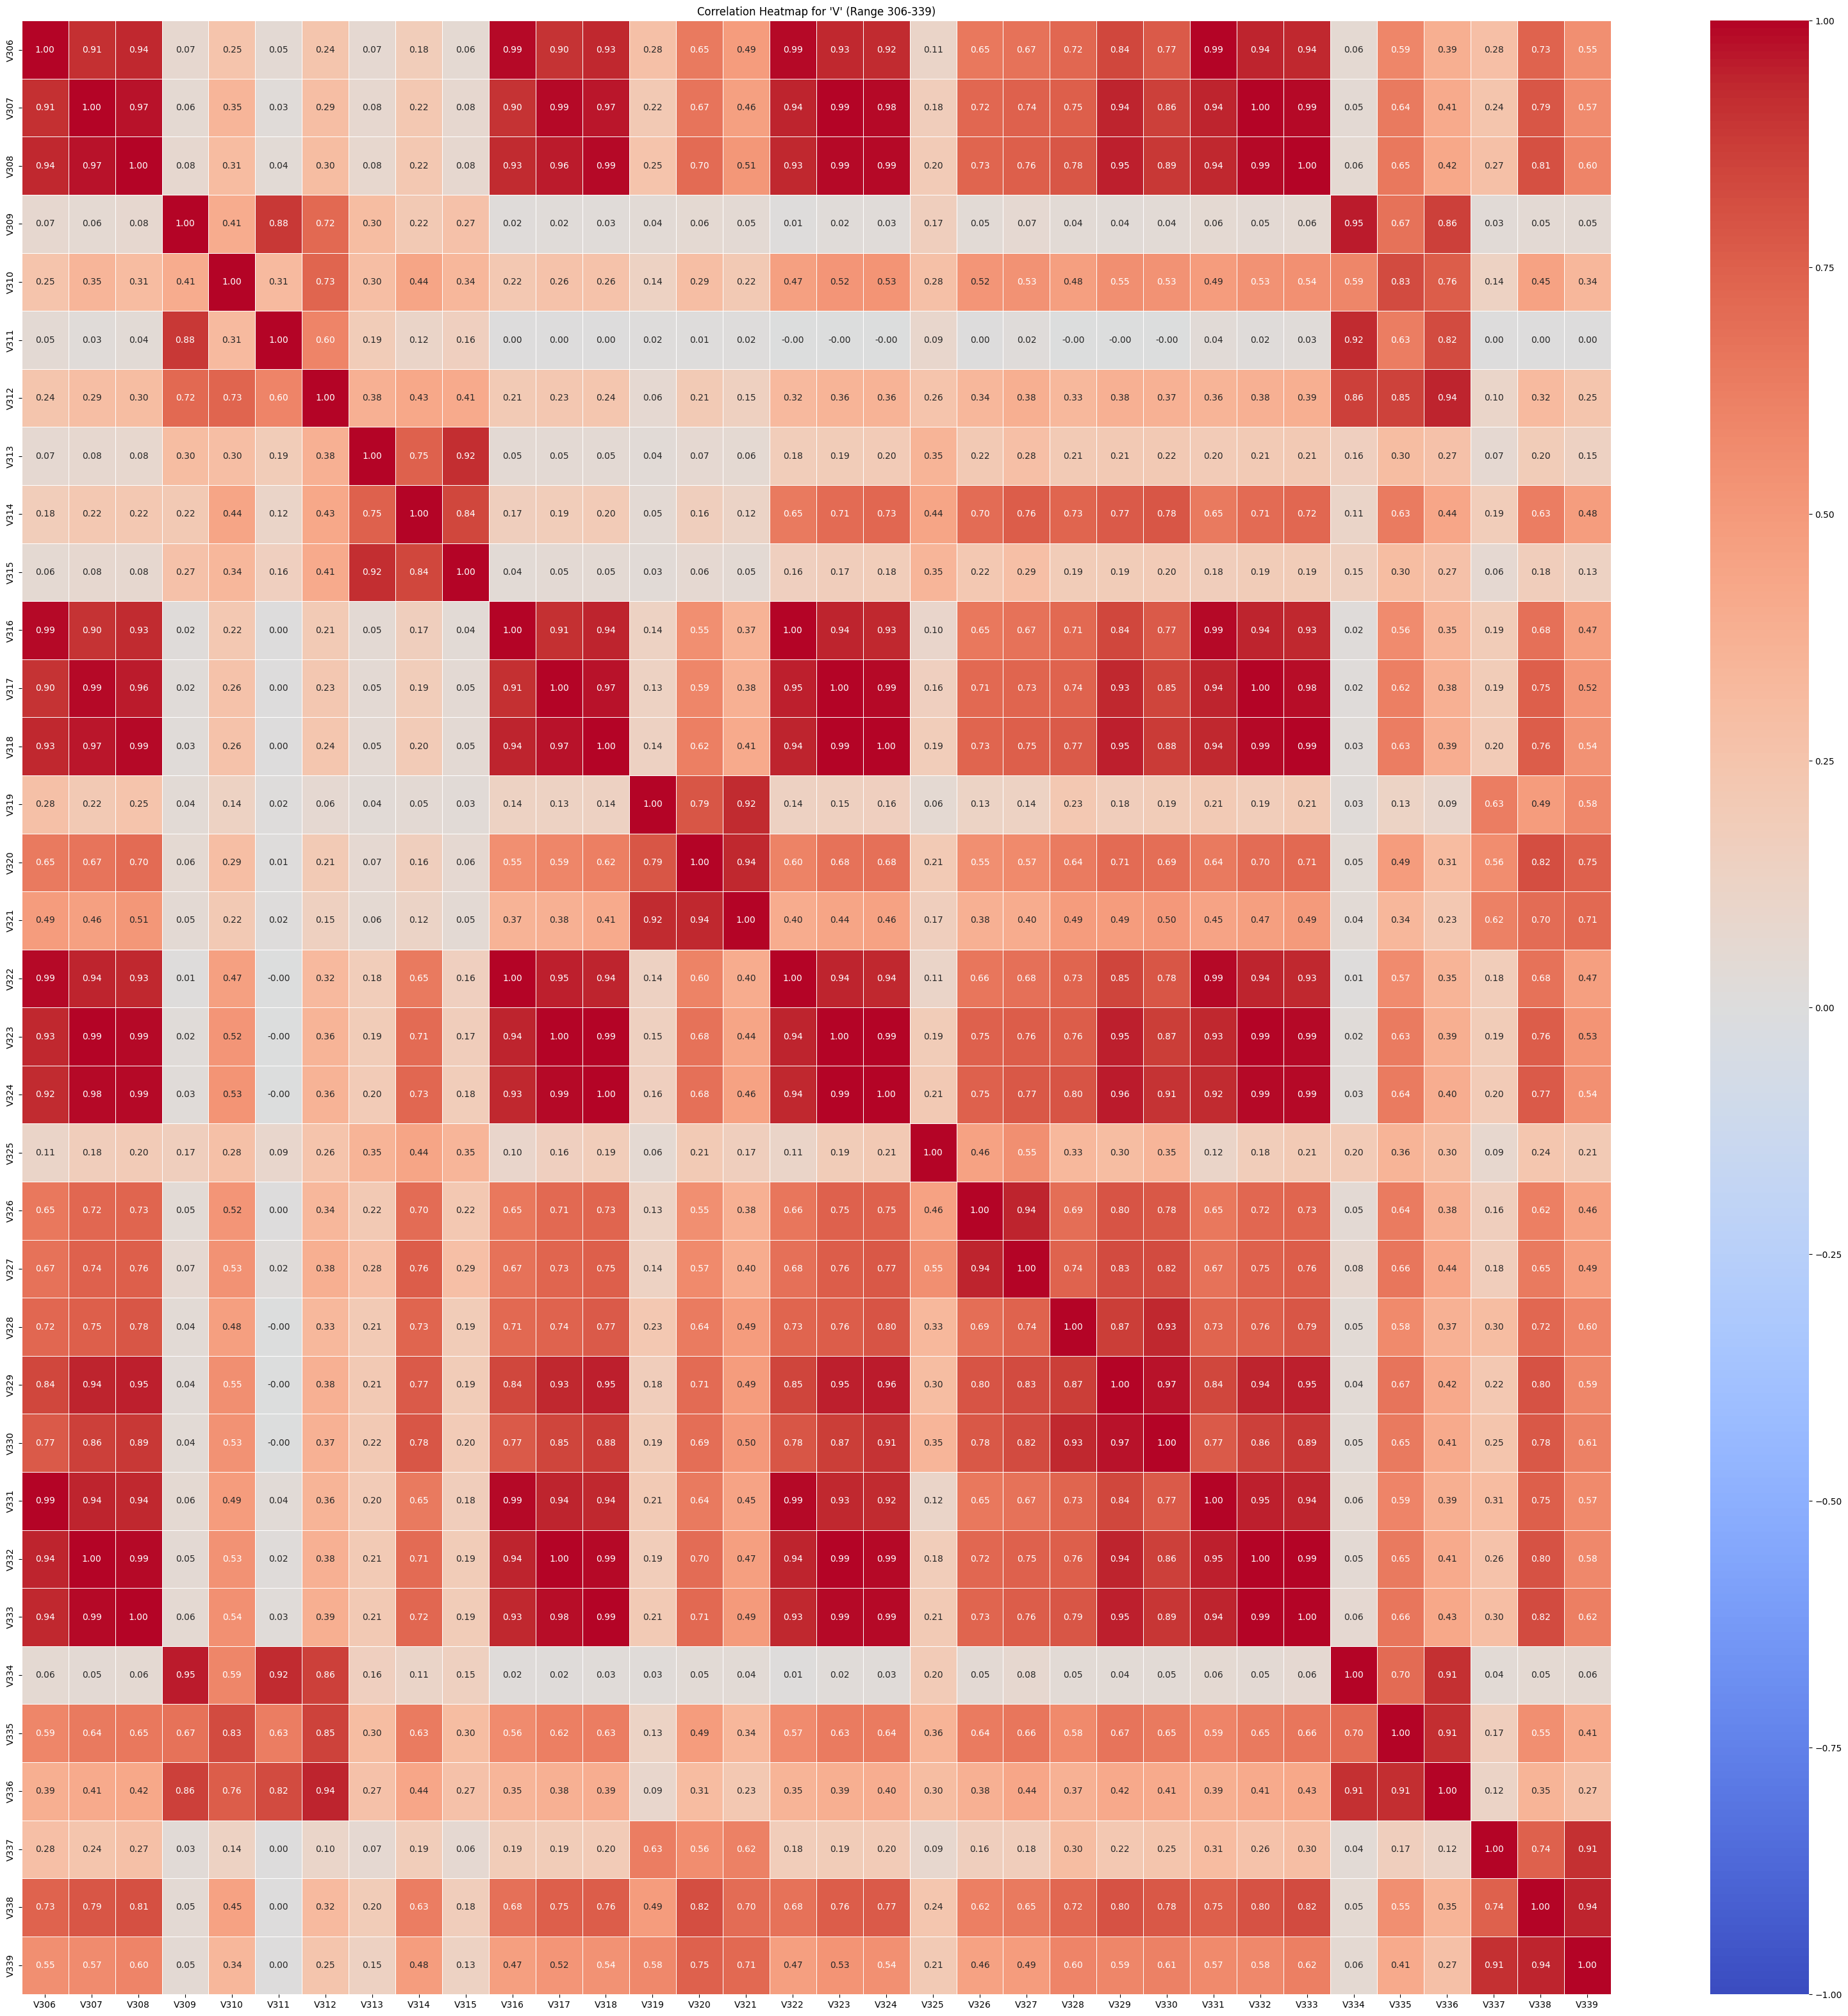

In [ ]:
def plot_correlation_by_range(df, prefix, start, end, figsize=(10, 8), cmap="coolwarm"):
    """
    Plots a correlation heatmap for features in the dataframe that start with a given prefix
    and fall within a specified numeric range (e.g., 'V1' to 'V14').

    Parameters:
    - df: DataFrame containing the dataset.
    - prefix: String prefix to filter features (e.g., 'V').
    - start: Starting number of the feature range.
    - end: Ending number of the feature range.
    - figsize: Tuple for figure size (default: (10, 8)).
    - cmap: Color map for heatmap (default: "coolwarm").

    Returns:
    - Displays a heatmap of the selected feature correlations.
    """
    # Select features that match the prefix and are within the specified range
    selected_cols = [col for col in df.columns if col.startswith(prefix) and
                     re.search(r'\d+', col) and start <= int(re.search(r'\d+', col).group()) <= end]

    if len(selected_cols) < 2:
        print(f"Not enough features found with prefix '{prefix}' in range {start}-{end} to compute correlation.")
        return

    # Compute correlation matrix
    corr_matrix = df[selected_cols].corr()

    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5, vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap for '{prefix}' (Range {start}-{end})")
    plt.show()
#170 - 184
plot_correlation_by_range(train_transaction, prefix="V", start=306, end=339, figsize=(40, 40))

## Partitioning of V's:


According to the correlation matrix of the whole V's there are certain ranges that are highly correlated and others not.
* V1 - V14
* V15 - V34
* V35 - V94
* V94 - V106
* (V94 - V106) : (126 - 137)
* (V94 - V106) : (163 - 186)
* (V94 - V106) : (203 - 220)
* (V94 - V106) : (231 - 238)
* (V94 - V106) : (268 - 278)
* (V94 - V106) : (289 - 306)
* (V94 - V106) : (314 - 332)
* (107 - 122)
* (107 - 122) : (126 - 137)
* (107 - 122) : (163 - 186)
* (107 - 122) : (203 - 220)
* (107 - 122) : (231 - 238)
* (107 - 122) : (268 - 278)
* (107 - 122) : (289 - 306)
* (107 - 122) : (314 - 332)
* 130 - 162
* 164 - 184
* 177 - 184
* 203 - 220
* 221 - 238
* 240 - 278
* 279 - 306
* 307 - 339

**Note:** Empty slots in the heatmap with correlation matrix means NaN.
* If a feature has many missing values, correlation calculations might result in NaN (Not a Number). This happens when a column is completely empty or contains constant values (i.e., no variance).
* If a feature has the same value for all rows, it has zero variance and cannot be correlated with other features.
* Incompatible data types.

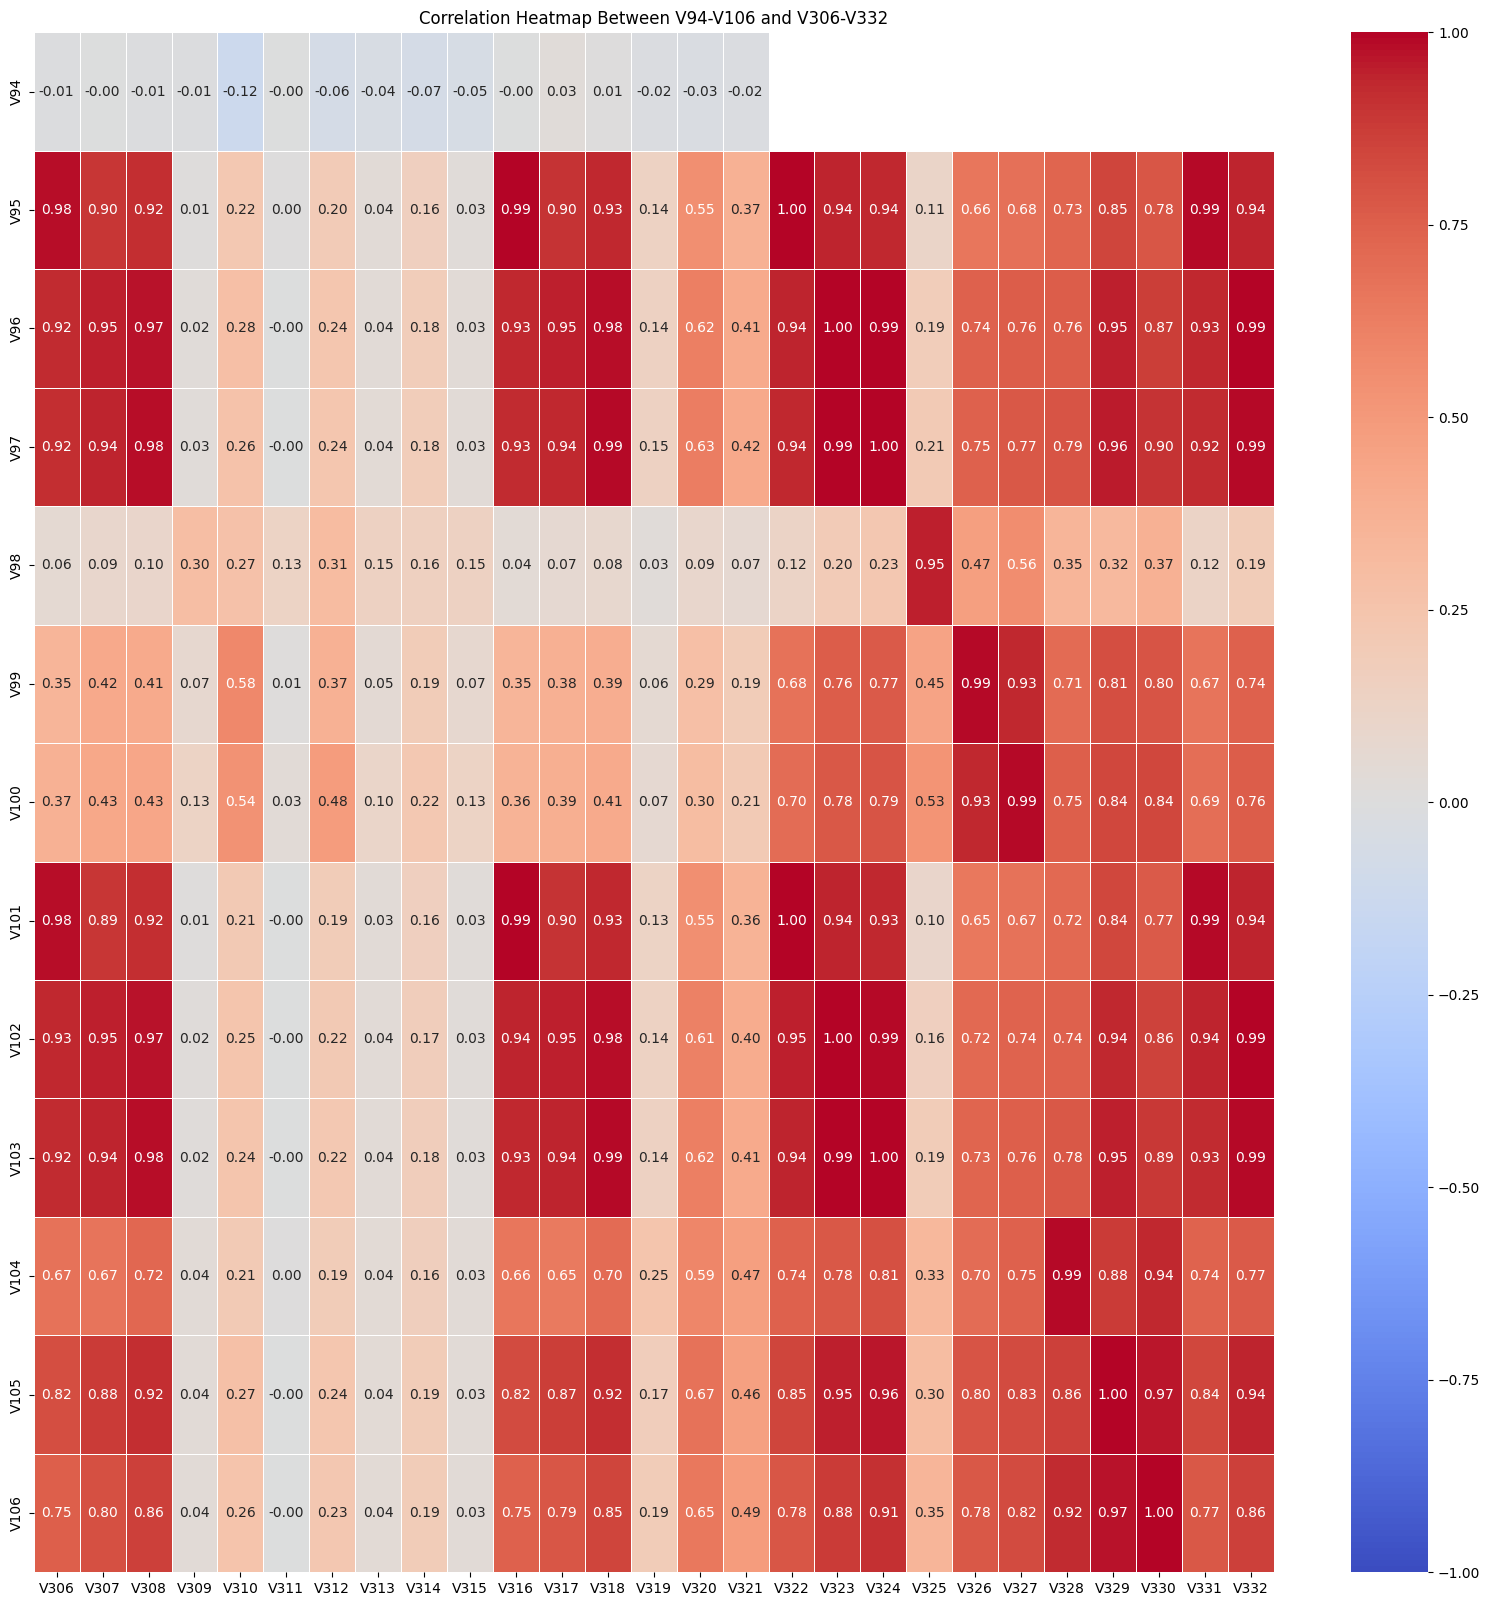

In [ ]:
def plot_correlation_between_ranges(df, range1, range2, prefix="V", figsize=(12, 8), cmap="coolwarm"):
    """
    Plots a correlation heatmap between two different feature ranges.

    Parameters:
    - df: DataFrame containing the dataset.
    - range1: Tuple (start, end) for the first feature range.
    - range2: Tuple (start, end) for the second feature range.
    - prefix: Common prefix of the features (default: "V").
    - figsize: Figure size for the heatmap (default: (12, 8)).
    - cmap: Color map for the heatmap (default: "coolwarm").

    Returns:
    - Displays a correlation heatmap between the selected feature groups.
    """
    # Select features from the first range
    cols1 = [f"{prefix}{i}" for i in range(range1[0], range1[1] + 1) if f"{prefix}{i}" in df.columns]

    # Select features from the second range
    cols2 = [f"{prefix}{i}" for i in range(range2[0], range2[1] + 1) if f"{prefix}{i}" in df.columns]

    # Ensure we have valid columns
    if len(cols1) == 0 or len(cols2) == 0:
        print("No matching columns found for the given ranges.")
        return

    # Compute correlation matrix between the two ranges
    corr_matrix = df[cols1 + cols2].corr().loc[cols1, cols2]

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5, vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap Between {prefix}{range1[0]}-{prefix}{range1[1]} and {prefix}{range2[0]}-{prefix}{range2[1]}")
    plt.show()

# Example usage:

plot_correlation_between_ranges(train_transaction, (94, 106), (306, 332), prefix="V", figsize=(20, 20))


## Chosen Features:
1. Addr are completely not correlated.

2. ProductCD and P_emaildomain: not correlated.

3. C's analysis:
  *C1 , C2, C4, C6, C7, C8, C10, C11, C12, C14 are highly correlated need to choose one between them.
  *  C5, C9, C13 are highly correlated.
4.D analysis:
  * D1 & D2 are highly correlated.
  * D3: D7
  * D4: D6, D10 are highly correlated.
  * D5 & D7 are highly correlated.
  * D5: D7
  * D6: D12 highly correlated
  * D12: D15 correlated

5. dist no correlation

6. M:
  * M1, M2, M3 correlated
  * M7, M8

7. TransactionID & Transaction DT highly correlated 1. (Don't remove any TransactionDT is significant for time & TransactionID for merging)

8. For the V's :) we are going to choose only the highly correlated
  * 1 -14: each pair starting from 2 to 13 are highly correlated
  * 15 -18 ,21-22, 31-34
  * 19-20
  * 23-24
  * 25-26
  * 27-28
  * 29-30
  * 35-36
  * 37-38
  * 44-45
  * 46-47
  * 48-49
  * 38-40-42-43-[50-52]
  * [57-60]-[71-74]
  * 61-62
  * 75-76
  * 77-78
  * [79-81]-[92-94]
  * 82-83
  * 84-85
  * 86-87
  * 90-91
  * [95-97]-[101-106]-[126-128]-[132-134]-164-165-167-168-[177-183]-203-204-[211-213]-[217-219]-[231-232]-279-280 - [293-299]-[306-308] -[316-318]-[320-324]-[327-332]
  * 99-100
  * [108-110]
  * [111-113]
  * 114-116
  * 117-119
  * 120-122
  * 130-131
  * [132- 134] -143
  * [135-137]
  * 139-140
  * 144-145-[150-152]-159-160
  * 146-147
  * 148-149-[153-158]
  * 159-160
  * 161-162
  * [177-183]
  * [186-187]-[190-193]-196-199
  * 188-189
  * 194-195-197-198
  * 196-207
  * 200-201
  * [202-204]
  * [214-216]
  * [217-219]
  * 221-222-259
  * 224-225
  * [217-219] - [231-237] - [273-275]
  * 238-239
  * 240-241
  * [242-243]-248-249-252-253-254
  * 245-259
  * [247-249]
  * 250-251
  * 255-256
  * 257-258
  * [260-262]
  * [263-265]
  * [266-269]
  * [270-272]
  * [273-275]
  * [276-278]
  * 279-280 - [293-299]
  * 285-287
  * 288-289
  * [290-292]
  * 300-301
  * [302-304]
  * [306-308]-[316-318]-[322-324]-[326-333]
  * 309-312-311
  * [313-315]
  * [319-321]
  * [334-336]
  * [337-339]


# 5. Feature Selection (Removing):

In [ ]:
def count_missing_values(df, columns):
    """
    Counts the number of missing values for each specified column in the DataFrame.

    Parameters:
    - df: DataFrame containing the dataset.
    - columns: List of column names to check for missing values.

    Returns:
    - A dictionary with column names as keys and the count of missing values as values.
    """
    missing_counts = {col: df[col].isna().sum() for col in columns if col in df.columns}

    return missing_counts
missing_values = count_missing_values(train_transaction, [f"card{i}" for i in range(1,6)])
print([int(value) for value in missing_values.values()])

[0, 8933, 1565, 1577, 4259]


## Selection in the small number of features:
* As a criteria to follow we removed those with many missing values:
* Keep all the C's for there are no missing values

* D: D1, D2, D3, D5, D6, D9, D10, D11, D15

* Keep all the M's

* Keep all cards


## V Selection:

Choose the V's with the same number of missing values, correlated, and the one with more variations in its values.
This criteria is followed to avoid loss of any essential information later on in XGBoost.

In [ ]:
def parse_feature_ranges(prefix, feature_str):
    """
    Parses a feature string like '38-40-42-43-[50-52]' into a list of feature names.

    Parameters:
    - prefix: The prefix for the features (e.g., 'V').
    - feature_str: A string representing individual features and ranges.

    Returns:
    - A list of formatted feature names.
    """
    features = []
    elements = feature_str.split("-")

    for elem in elements:
        if "[" in elem and "]" in elem:  # Detect ranges
            range_match = re.findall(r"\[(\d+)-(\d+)\]", elem)
            if range_match:
                start, end = map(int, range_match[0])
                features.extend([f"{prefix}{i}" for i in range(start, end + 1)])
        else:
            features.append(f"{prefix}{elem}")

    return features


def select_features_by_missing_values(df, prefix, feature_str):
    """
    Selects features with the same number of missing values and keeps the one with the most unique values.

    Parameters:
    - df: DataFrame containing the dataset.
    - prefix: Feature prefix (e.g., 'V').
    - feature_str: String representing feature numbers and ranges (e.g., '38-40-42-43-[50-52]').

    Returns:
    - List of selected column names.
    """
    # Extract feature names from the input string
    columns = parse_feature_ranges(prefix, feature_str)

    # Dictionary to store missing values count for each column
    missing_counts = {col: df[col].isna().sum() for col in columns if col in df.columns}

    # Group columns by their missing value count
    grouped = {}
    for col, count in missing_counts.items():
        if count not in grouped:
            grouped[count] = []
        grouped[count].append(col)

    # Select the column with the highest unique values in each group
    selected_features = []
    for count, cols in grouped.items():
        if len(cols) > 1:
            best_col = max(cols, key=lambda col: df[col].nunique())
            selected_features.append(best_col)
        else:
            selected_features.append(cols[0])

    return selected_features

# Example usage:
# selected_features = select_features_by_missing_values(train_transaction, "V", "23-24")
# print(selected_features)


In [ ]:
selected_features = select_features_by_missing_values(train_transaction, "V", "337-338-339")
print(selected_features)

['V338']


* V1-V14: 1, 3, 4, 6, 8, 11, 13, 14
* V15-38: 17, 20, 22, 23, 26, 27, 30, 36, 37
* V35-V94: 40, 41, 42, 44, 47, 48, 52, 54, 59, 62, 63, 65, 67, 68, 70, 76, 78, 80, 82, 84, 86, 88, 89, 91, 99
* Here we are removing from this wide ranges:
  * [95-97]-[101-106]-[126-128]-[132-134]-164-165-167-168-[177-183]-202-203-204-[211-213]-[217-219]-[231-232]-279-280 - [293-299]-[306-308] -[316-318]-[322-324]-[329-333]: 127, 165, 203, 180, 218, 307, 296, 332
  * format for function: (95-96-97-101-102-103-105-106-126-127-128-132-133-134-143-164-165-167-168-177-178-179-180-182-183-202-203-204-211-212-213-217-218-219-231-232-233-279-280-293-294-295-296-297-298-299-306-307-308-316-317-318-322-323-324-329-330-331-332-333)
* V107-V129: 108, 109, 111, 114, 115, 117, 118, 120, 121, 123, 124, 129
* V130-V163: 130, 131, 136, 138, 139, 142, 143, 150, 147, 155, 160, 162
* V164-V184: 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 185
* V186-V203: 190, 187, 188, 195, 198, 201
* V203-V220: 205, 206, 207, 208, 209, 210, 216, 220
* V221-V238: 221, 223, 224, 226, 227, 228, 229, 238
* V240-V278: 240, 241, 242, 243, 245, 246, 248, 249, 250, 253, 256, 258, 259, 260, 263, 264, 266, 267, 269, 270, 271, 272, 273, 274, 275, 276
* V279-V306: 280, 283, 285, 286, 287, 289, 291, 301, 303
* V307-V339: 309, 313, 310, 320, 325, 335, 338